In [1]:
MAX_LEN = 80
TASK = 0

In [2]:
datadir = "../data/"
trainpath = datadir+"olid-training-v1.0.tsv"
testpath = datadir+"testset-level{}.tsv".format("abc"[TASK])
labelpath = datadir+"labels-level{}.csv".format("abc"[TASK])

### Prerequisites

In [3]:
# !pip install --user wordninja
# import nltk
# nltk.download('averaged_perceptron_tagger')

In [4]:
from dataset import make_data_generator
from models import SimpleLSTM as IsaV1, Criterion
import torch

In [5]:
training_set, training_gen = make_data_generator(trainpath, task=TASK, batch_size=32, n_workers=4,\
                                                 max_len=MAX_LEN, shuffle=True)

[info] 13240 data.



[info] vocab size = 16375


In [6]:
VOCAB = (training_set.vocab, training_set.pos_vocab)
VOC_SIZE = len(VOCAB[0])
POS_SIZE = len(VOCAB[1])

In [7]:
model = IsaV1(demb=100, demb_pos=128, dmodel=120, dff=150, \
            voc_sz=VOC_SIZE, pos_voc_sz=POS_SIZE, max_len=MAX_LEN,\
            out_class=(3 if TASK==2 else 2), dropout=0.5)

model.train()
model.cuda()

SimpleLSTM(
  (encoder): Sequential(
    (0): Embedding(16375, 100)
    (1): LSTM(100, 120, batch_first=True, bidirectional=True)
  )
  (pos_encoder): Sequential(
    (0): Embedding(38, 128)
    (1): LSTM(128, 120, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.5)
  (FFN): Sequential(
    (0): Linear(in_features=480, out_features=150, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [8]:
criterion = Criterion(TASK, cuda=True)
optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)

In [9]:
EPOCHS = 20

for i,e in enumerate(range(EPOCHS)):
    running_loss = 0
    running_accu = 0
    running_step = 0
    
    for j, (x, pos, y) in enumerate(training_gen):
        x = x.cuda()
        pos = pos.cuda()
        y = y.cuda()

        logits = model.forward(x, pos)
        loss = criterion.loss_compute(logits, y)
        accu = criterion.accu_compute(logits, y)

        optim.zero_grad()
        loss.backward()
        optim.step()        
        
        running_loss += loss.item()
        running_accu += accu.item()
        running_step += 1        
        print(loss.item(), end='\r')
        
    print("Epoch", i, "Loss:", running_loss/running_step, "Accu:", running_accu/running_step)
torch.save(model, "tmp.pkt")

Epoch 0 Loss: 0.6227673816220196 Accu: 0.6677989130434783
Epoch 1 Loss: 0.5592466207662067 Accu: 0.7077294685990339
Epoch 2 Loss: 0.4983363785029609 Accu: 0.752239331819009
Epoch 3 Loss: 0.43852848617207024 Accu: 0.789829911529154
Epoch 4 Loss: 0.3838907975865447 Accu: 0.8243760064892147
Epoch 5 24475097656Loss: 0.32247588628732066 Accu: 0.8571608294035502
Epoch 6 Loss: 0.27075939019017176 Accu: 0.8860960144927537
Epoch 7 Loss: 0.21728058865266867 Accu: 0.9110809178743962
Epoch 8 Loss: 0.1683290524336235 Accu: 0.9317129630109539
Epoch 9 Loss: 0.13506353103695212 Accu: 0.9485960144927537
Epoch 10 Loss: 0.10892084259359877 Accu: 0.9589371980676329
Epoch 11 Loss: 0.08475253778815738 Accu: 0.9680706521739131
Epoch 12 Loss: 0.07957287967724698 Accu: 0.9725996376811594
Epoch 13 Loss: 0.06479138861706138 Accu: 0.9776821659095045
Epoch 14 Loss: 0.05677299460301689 Accu: 0.9795189211909897
Epoch 15 Loss: 0.047321782669261694 Accu: 0.9829408212560387
Epoch 16 Loss: 0.04751925344369712 Accu: 0.98

[info] 860 data.



[info] vocab size = 16375


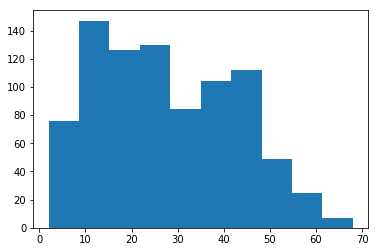

In [10]:
model = torch.load("tmp.pkt")
testing_set, testing_gen = make_data_generator(testpath, task=TASK, testlabel=labelpath, \
                                               batch_size=1024, n_workers=4, load_vocabs=VOCAB,\
                                               max_len=MAX_LEN, shuffle=False)

In [11]:
running_loss = 0
running_accu = 0
running_step = 0
with torch.no_grad():
    for j, (x, pos, y) in enumerate(testing_gen):
        x = x.cuda()
        pos = pos.cuda()
        y = y.cuda()

        logits = model.forward(x, pos)
        loss = criterion.loss_compute(logits, y)
        accu = criterion.accu_compute(logits, y)

        running_loss += loss.item()
        running_accu += accu.item()
        running_step += 1
        
print("Evaludation Loss:", running_loss/running_step, "Accu:", running_accu/running_step)

Evaludation Loss: 2.0410616397857666 Accu: 0.7209302186965942
